# WESAD dataset processing

In [1]:
import os
import pickle
from datetime import datetime as dt
from dateutil import tz
from pathlib import Path
import pytz

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)
import neurokit2 as nk

from scipy.fft import fft, fftfreq, ifft
from scipy.signal import firwin, filtfilt, iirnotch, convolve
from scipy.stats import norm

## Processing functions 

In [2]:
def load_subject_pickle_data(data_dir, sub_id):
    print(f"working on subject {sub_id}")
    # load subject EDA data and labels
    sub_data = pickle.load(open(os.path.join(data_dir, f"{sub_id}", f"{sub_id}.pkl"), "rb"), encoding='latin1')
    print(f"Loaded data")
    labels = sub_data['label']
    EDA = sub_data['signal']['wrist']['EDA']
    LABEL_SAMPLE_RATE = 700
    EDA_SAMPLE_RATE = 4
    assert labels.shape[0] / LABEL_SAMPLE_RATE == EDA.shape[0] / EDA_SAMPLE_RATE, "labels and EDA are not aligned"
    
    # assign timestamps to EDA data and labels
    # putting random year, day, month, because doesn't matter
    start_dt = dt(2017, 11, 28, 0, 0, 0, 0)
    label_freq = pd.DateOffset(seconds=1/LABEL_SAMPLE_RATE)
    label_times = pd.date_range(start=start_dt, periods=labels.shape[0], freq=label_freq, tz="UTC")
    label_df = pd.DataFrame({"label_sample_timestamp_utc": label_times, "y": list(labels)})
    EDA_freq = pd.DateOffset(seconds=1/EDA_SAMPLE_RATE)
    EDA_times = pd.date_range(start=start_dt, periods=EDA.shape[0], freq=EDA_freq, tz="UTC")
    EDA_df = pd.DataFrame({"eda_sample_timestamp_utc": EDA_times, "eda": list(EDA.flatten())})
    
    print(f"label shape {label_df.shape}")
    print(f"EDA shape {EDA_df.shape}")
    
    # add labels to EDA_df
    EDA_df = pd.merge_asof(EDA_df, label_df, left_on="eda_sample_timestamp_utc", right_on="label_sample_timestamp_utc", direction="nearest")
    
    # drop label timestamp column
    EDA_df.drop(columns="label_sample_timestamp_utc", inplace=True)
    
    # make timestamp index
    EDA_df.set_index("eda_sample_timestamp_utc", inplace=True, drop=False)
    
    return EDA_df

In [3]:
def create_segments(
    eda_df, 
    segment_length, 
    segment_stride,
):
    """
    segment_lenght and segment_stride should be given in # of samples, NOT seconds    
    NOTE: no adherence checking but I think that's okay
    """
    begin_dts = []
    end_dts = []
    eda_segs = []
    label_segs = []
    left_buffers = []
    right_buffers = []
    for i in range(1, len(eda_df) - segment_length, segment_stride):
        begin_dts.append(eda_df["eda_sample_timestamp_utc"][i])
        end_dts.append(eda_df["eda_sample_timestamp_utc"][i+segment_length-1])
        eda_seg = eda_df["eda"][i:i + segment_length]
        eda_segs.append(list(eda_seg))
        label_segs.append(list(eda_df["y"][i:i+segment_length]))
        # get left buffer
        if i - segment_length >= 0:
            left_buffers.append(list(eda_df["eda"][i-segment_length:i]))
        else:
            left_buffer = np.full_like(eda_seg, np.nan)
            remaining_left_values = eda_df["eda"][:i]
            left_buffer[-remaining_left_values.shape[0]:] = remaining_left_values
            left_buffers.append(left_buffer)
            # left_buffers.append(list(eda_df["eda"][0:segment_length]))
            print(f"using left fill, {i=}")
        
        # get right buffer
        if i + (2*segment_length) < len(eda_df):
            right_buffers.append(list(eda_df["eda"][i+segment_length:i+(2*segment_length)]))
        else:
            right_buffer = np.full_like(eda_seg, np.nan)
            remaining_right_values = eda_df["eda"][i+segment_length:]
            right_buffer[:remaining_right_values.shape[0]] = remaining_right_values
            right_buffers.append(right_buffer)
            print(f"using right fill, {i=}, {len(eda_df)=}")
    
    # create dataframe
    df_dict = {"segment_start_datetime_utc": begin_dts, "segment_end_datetime_utc": end_dts, "y": label_segs}
    eda_segs = np.array(eda_segs)
    eda_segs_dict = {f"x_{i}": eda_segs[:, i] for i in range(eda_segs.shape[1])}
    df_dict.update(eda_segs_dict)
    left_buffers = np.array(left_buffers)
    left_buffer_dict = {f"x_left_buffer_{i}": left_buffers[:, i] for i in range(left_buffers.shape[1])}
    df_dict.update(left_buffer_dict)
    right_buffers = np.array(right_buffers)
    right_buffer_dict = {f"x_right_buffer_{i}": right_buffers[:, i] for i in range(right_buffers.shape[1])}
    df_dict.update(right_buffer_dict)
    eda_segments_df = pd.DataFrame(df_dict)
    return eda_segments_df

In [4]:
def process_subject_data(
    data_dir, 
    sub_id, 
    output_dir, 
    segment_length=240, 
    segment_stride=1,
    subsample_50_50=False,
):
    
    EDA_df = load_subject_pickle_data(data_dir, sub_id)
    
    # check that all timestamps are included
    all_ts = pd.date_range(
                EDA_df.index.min().astimezone(pytz.utc),
                EDA_df.index.max().astimezone(pytz.utc),
                freq=pd.DateOffset(seconds=0.25),
            )
    assert len(EDA_df) == len(all_ts), f"EDA DF for subject {sub_id} does not include all timestamps"    
    
    # segment data
    EDA_segment_df = create_segments(EDA_df, segment_length, segment_stride)
    
    # map list of labels for each segment to single label (throw out segments that include multiple labels)
    def agg_labels(label_list):
        label_set = set(label_list)
        if len(label_set) != 1:
            return np.NAN
        return label_list[0]
    EDA_segment_df["y"] = EDA_segment_df["y"].apply(lambda x: agg_labels(x))
    
    # get version of EDA with only the desired labels
    EDA_labelled_df = EDA_segment_df[EDA_segment_df["y"].isin([1, 2])]
    print(f"{len(EDA_labelled_df)} examples are stress/no-stress; whole dataset has {len(EDA_segment_df)} examples")
    
    # subsample data to be 50-50 stress/no-stress
    if subsample_50_50:
        pos_df = EDA_labelled_df[EDA_labelled_df["y"] == 2]
        neg_df = EDA_labelled_df[EDA_labelled_df["y"] == 1]
        pos_count = len(pos_df)
        neg_count = len(neg_df)
        print(f"pos count {pos_count}, neg_count {neg_count}")
        remove_count = np.abs(pos_count - neg_count)
        if pos_count > neg_count:
            remove_idx_i = np.random.choice(len(pos_df), size=remove_count, replace=False)
            remove_idx = pos_df.iloc[remove_idx_i].index
        else:
            remove_idx_i = np.random.choice(len(neg_df), size=remove_count, replace=False)
            remove_idx = neg_df.iloc[remove_idx_i].index

        EDA_labelled_df.drop(labels=remove_idx, inplace=True)
        
        # get updated pos/neg counts
        pos_df = EDA_labelled_df[EDA_labelled_df["y"] == 2]
        neg_df = EDA_labelled_df[EDA_labelled_df["y"] == 1]
        pos_count = len(pos_df)
        neg_count = len(neg_df)
        print(f"updated, pos count {pos_count}, neg_count {neg_count}")
    
    # get unlabelled dataset - drop label column from unlabelled df
    EDA_unlabelled_df = EDA_segment_df.drop(columns="y")
    
    # save dataframes -- TODO: drop index???
    if not os.path.exists(os.path.join(output_dir, sub_id)):
        os.makedirs(os.path.join(output_dir, sub_id))
    EDA_labelled_df.to_csv(os.path.join(output_dir, sub_id, "EDA_labelled.csv"))
    EDA_unlabelled_df.to_csv(os.path.join(output_dir, sub_id, "EDA_unlabelled.csv"))
    
    return EDA_labelled_df, EDA_unlabelled_df

## Process WESAD data with stride of 1 sample

### Example with dataset from only 1 participant

In [7]:
s10_labelled_stride1, s10_unlabelled_stride1 = (
    process_subject_data(
        "../../../biosignal-datasets/WESAD/WESAD/", "S10", "WESAD_TEST",
        segment_length=240, segment_stride=1,
    )
)

working on subject S10
Loaded data
label shape (3847200, 2)
EDA shape (21984, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
using left fill, i=40
using left fill, i=41
using left fill, i=42
usin

7144 examples are stress/no-stress; whole dataset has 21743 examples


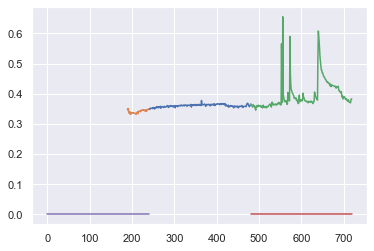

In [10]:
SEGMENT_IX = 50
s10_unlabelled_stride1 = s10_unlabelled_stride1.reset_index(drop=True)
central_segments = s10_unlabelled_stride1.iloc[SEGMENT_IX][[f"x_{i}" for i in range(240)]]
left_buffers = s10_unlabelled_stride1.iloc[SEGMENT_IX][[f"x_left_buffer_{i}" for i in range(240)]]
right_buffers = s10_unlabelled_stride1.iloc[SEGMENT_IX][[f"x_right_buffer_{i}" for i in range(240)]]
plt.plot([i for i in range(240, 480, 1)], central_segments)
plt.plot([i for i in range(0, 240, 1)], left_buffers)
plt.plot([i for i in range(480, 720, 1)], right_buffers)
plt.plot([i for i in range(480, 720, 1)], np.zeros_like(right_buffers))
plt.plot([i for i in range(0, 240, 1)], np.zeros_like(right_buffers))

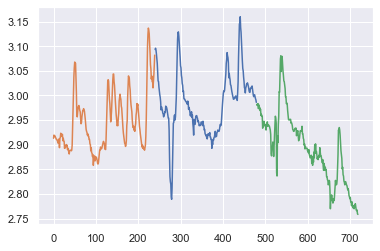

In [11]:
SEGMENT_IX = np.random.randint(low=0, high=s10_labelled_stride1.shape[0]-1)
s10_labelled_stride1 = s10_labelled_stride1.reset_index(drop=True)
central_segments = s10_labelled_stride1.iloc[SEGMENT_IX][[f"x_{i}" for i in range(240)]]
left_buffers = s10_labelled_stride1.iloc[SEGMENT_IX][[f"x_left_buffer_{i}" for i in range(240)]]
right_buffers = s10_labelled_stride1.iloc[SEGMENT_IX][[f"x_right_buffer_{i}" for i in range(240)]]
plt.plot([i for i in range(240, 480, 1)], central_segments)
plt.plot([i for i in range(0, 240, 1)], left_buffers)
plt.plot([i for i in range(480, 720, 1)], right_buffers)

## Process the full WESAD dataset

In [92]:
WESAD_DATA_DIR = "../../../biosignal-datasets/WESAD/WESAD/"
WESAD_OUTPUT_DIR = "WESAD_processed_28012023/"

In [94]:
SEGMENT_LENGTH = 240
SEGMENT_STRIDE = 1

# run on all subjects
for sub_id in os.listdir(WESAD_DATA_DIR):
    if sub_id.startswith("S"):
        process_subject_data(
            WESAD_DATA_DIR, sub_id, WESAD_OUTPUT_DIR, 
            segment_length=SEGMENT_LENGTH, segment_stride=SEGMENT_STRIDE,
        )

working on subject S5
Loaded data
label shape (4380600, 2)
EDA shape (25032, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
using left fill, i=40
using left fill, i=41
using left fill, i=42
using

6897 examples are stress/no-stress; whole dataset has 24791 examples
working on subject S2
Loaded data
label shape (4255300, 2)
EDA shape (24316, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
us

6560 examples are stress/no-stress; whole dataset has 24075 examples
working on subject S3
Loaded data
label shape (4545100, 2)
EDA shape (25972, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
us

6644 examples are stress/no-stress; whole dataset has 25731 examples
working on subject S4
Loaded data
label shape (4496100, 2)
EDA shape (25692, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
us

6696 examples are stress/no-stress; whole dataset has 25451 examples
working on subject S17
Loaded data
label shape (4144000, 2)
EDA shape (23680, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
u

7140 examples are stress/no-stress; whole dataset has 23439 examples
working on subject S10
Loaded data
label shape (3847200, 2)
EDA shape (21984, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
u

7144 examples are stress/no-stress; whole dataset has 21743 examples
working on subject S11
Loaded data
label shape (3663100, 2)
EDA shape (20932, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
u

6965 examples are stress/no-stress; whole dataset has 20691 examples
working on subject S16
Loaded data
label shape (3941700, 2)
EDA shape (22524, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
u

6937 examples are stress/no-stress; whole dataset has 22283 examples
working on subject S8
Loaded data
label shape (3826200, 2)
EDA shape (21864, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
us

6879 examples are stress/no-stress; whole dataset has 21623 examples
working on subject S6
Loaded data
label shape (4949700, 2)
EDA shape (28284, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
us

6844 examples are stress/no-stress; whole dataset has 28043 examples
working on subject S7
Loaded data
label shape (3666600, 2)
EDA shape (20952, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
us

6829 examples are stress/no-stress; whole dataset has 20711 examples
working on subject S9
Loaded data
label shape (3656100, 2)
EDA shape (20892, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
us

6824 examples are stress/no-stress; whole dataset has 20651 examples
working on subject S13
Loaded data
label shape (3875900, 2)
EDA shape (22148, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
u

6901 examples are stress/no-stress; whole dataset has 21907 examples
working on subject S14
Loaded data
label shape (3883600, 2)
EDA shape (22192, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
u

6944 examples are stress/no-stress; whole dataset has 21951 examples
working on subject S15
Loaded data
label shape (3676400, 2)
EDA shape (21008, 2)
using left fill, i=1
using left fill, i=2
using left fill, i=3
using left fill, i=4
using left fill, i=5
using left fill, i=6
using left fill, i=7
using left fill, i=8
using left fill, i=9
using left fill, i=10
using left fill, i=11
using left fill, i=12
using left fill, i=13
using left fill, i=14
using left fill, i=15
using left fill, i=16
using left fill, i=17
using left fill, i=18
using left fill, i=19
using left fill, i=20
using left fill, i=21
using left fill, i=22
using left fill, i=23
using left fill, i=24
using left fill, i=25
using left fill, i=26
using left fill, i=27
using left fill, i=28
using left fill, i=29
using left fill, i=30
using left fill, i=31
using left fill, i=32
using left fill, i=33
using left fill, i=34
using left fill, i=35
using left fill, i=36
using left fill, i=37
using left fill, i=38
using left fill, i=39
u

6968 examples are stress/no-stress; whole dataset has 20767 examples
